In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython import display
import torchsummary as ts
import numpy as np

In [2]:
sns.set()
display.set_matplotlib_formats("svg")
plt.rcParams['font.sans-serif'] = "Liberation Sans"
device = torch.device("cuda")

In [3]:
torch.cuda.is_available()

True

In [4]:
trans = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
dataset = datasets.ImageFolder("dataset/faces/", transform=trans)

In [6]:
data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, 
                        drop_last=True)

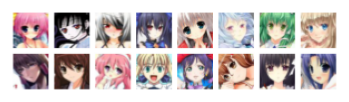

In [7]:
images = make_grid(next(iter(data_loader))[0], normalize=True, padding=5, pad_value=1)
plt.imshow(images.permute(1, 2, 0))
plt.axis("off")
plt.grid(False)

In [8]:
def imshow(data):
    
    images = make_grid(data.detach().cpu() , normalize=True, padding=5, pad_value=1)
    plt.imshow(images.permute(1, 2, 0))
    plt.axis("off")
    plt.grid(False)
    plt.pause(0.0001)

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=4, stride=2,
                     padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=4, stride=2,
                     padding=1),
            nn.BatchNorm2d(12),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=4, stride=2,
                     padding=1),
            nn.BatchNorm2d(24),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(24, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.main(x)
        x = x.reshape(-1)
        return x


In [11]:
class Generator(nn.Module):
    
    def __init__(self, init_size=100):
        super().__init__()
        self.expand_dim = nn.Linear(init_size, 1024)
        self.init_size = init_size
        self.main = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 12, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            
            nn.ConvTranspose2d(12, 3, kernel_size=4, 
                               stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.expand_dim(x).reshape(-1, 64, 4, 4)
        x = self.main(x)
        return x

In [12]:
netD = Discriminator()

In [13]:
netD(torch.randn(16, 3, 32, 32))

tensor([0.2658, 0.4041, 0.2701, 0.2702, 0.3783, 0.3695, 0.4010, 0.4240, 0.3865,
        0.3485, 0.4054, 0.4704, 0.3887, 0.4375, 0.3373, 0.4773],
       grad_fn=<ViewBackward>)

In [14]:
netG = Generator()

In [15]:
netG(torch.randn(16, 100)).shape

torch.Size([16, 3, 32, 32])

In [16]:
BATCH_SIZE = 64
ININT_SIZE = 100
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, 
                         shuffle=True, num_workers=4, drop_last=True)

In [17]:
Epoch = 1000
D_losses = []
G_losses = []

In [18]:
generator = Generator(ININT_SIZE).to(device)
discirminator = Discriminator().to(device)
generator.apply(weights_init)
discirminator.apply(weights_init)
criterion = nn.BCELoss()
OPTIMIZER_G = optim.Adam(generator.parameters(), lr=4e-4, betas=(0.5, 0.999))
OPTIMIZER_D = optim.Adam(discirminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [19]:
pdr, pdf, pg = None, None, None
for epoch in range(1, 1 + Epoch):
    dis_temp_loss = []
    gen_temp_loss = []
    for idx, (d, l) in enumerate(data_loader):
        
        d = d.to(device)
        l = l.float().to(device)
        
        out = discirminator(d)
        pdr = out.mean().item()
        real_loss = criterion(out, torch.ones_like(l))
        
        noise = torch.randn(BATCH_SIZE, ININT_SIZE).to(device)
        images = generator(noise)
        out = discirminator(images.detach().to(device))
        pdf = out.mean().item()
        fake_loss = criterion(out, torch.zeros_like(l))
        
        OPTIMIZER_D.zero_grad()
        real_loss.backward()
        fake_loss.backward()
        OPTIMIZER_D.step()
        
        noise = torch.randn(BATCH_SIZE, ININT_SIZE).to(device)
        images = generator(noise)
        out = discirminator(images)
        pg = out.mean().item()
        loss = criterion(out, torch.ones_like(l))
        
        OPTIMIZER_G.zero_grad()
        loss.backward()
        OPTIMIZER_G.step()
        
        d_loss = fake_loss + real_loss
        
        print("Epoch = {:<2} Step[{:3}/{:3}] Dis-Loss = {:.5f} Gen-Loss = {:.5f} acc = {} {} {}"\
              .format(epoch, idx + 1, len(data_loader), d_loss.item(), 
                      loss.item(), pdr, pdf, pg))
        
        dis_temp_loss.append(d_loss.item())
        gen_temp_loss.append(loss.item())
    D_losses.append(np.mean(dis_temp_loss))
    G_losses.append(np.mean(gen_temp_loss))
    
    if epoch > 1:
        fig, ax = plt.subplots()
        ax.plot(np.arange(len(D_losses)) + 1, 
                   D_losses, label="Discriminator", ls="-.")
        ax.plot(np.arange(len(G_losses)) + 1, 
                   G_losses, label="Generator", ls="--")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title("GAN Training process")
        ax.legend(bbox_to_anchor=[1, 1.02])
        plt.pause(0.0001)
        imshow(images[:16])
        imshow(d[:16])
    if epoch % 10 == 0:
        display.clear_output()

Epoch = 11 Step[  1/800] Dis-Loss = 1.38383 Gen-Loss = 0.72730 acc = 0.4860272705554962 0.4842662513256073 0.48328953981399536
Epoch = 11 Step[  2/800] Dis-Loss = 1.38039 Gen-Loss = 0.72655 acc = 0.486137717962265 0.4826032221317291 0.4836145043373108
Epoch = 11 Step[  3/800] Dis-Loss = 1.37738 Gen-Loss = 0.72841 acc = 0.4880523681640625 0.4830998182296753 0.4827190041542053
Epoch = 11 Step[  4/800] Dis-Loss = 1.38269 Gen-Loss = 0.72815 acc = 0.48720768094062805 0.4848710298538208 0.4828382730484009
Epoch = 11 Step[  5/800] Dis-Loss = 1.37848 Gen-Loss = 0.72858 acc = 0.4882913827896118 0.483909547328949 0.48263925313949585
Epoch = 11 Step[  6/800] Dis-Loss = 1.38180 Gen-Loss = 0.72358 acc = 0.4878328740596771 0.4851211905479431 0.48507219552993774
Epoch = 11 Step[  7/800] Dis-Loss = 1.37879 Gen-Loss = 0.72100 acc = 0.48954012989997864 0.4853658080101013 0.4863145351409912
Epoch = 11 Step[  8/800] Dis-Loss = 1.38134 Gen-Loss = 0.72638 acc = 0.48867276310920715 0.48573219776153564 0.4837

Epoch = 11 Step[ 69/800] Dis-Loss = 1.38830 Gen-Loss = 0.70141 acc = 0.4950682818889618 0.4957771897315979 0.4960212707519531
Epoch = 11 Step[ 70/800] Dis-Loss = 1.40036 Gen-Loss = 0.69662 acc = 0.49297988414764404 0.4997240900993347 0.4983243942260742
Epoch = 11 Step[ 71/800] Dis-Loss = 1.39794 Gen-Loss = 0.69660 acc = 0.4939170181751251 0.49950364232063293 0.4983483552932739
Epoch = 11 Step[ 72/800] Dis-Loss = 1.39786 Gen-Loss = 0.69875 acc = 0.49293187260627747 0.4984841048717499 0.49728745222091675
Epoch = 11 Step[ 73/800] Dis-Loss = 1.39656 Gen-Loss = 0.69670 acc = 0.49425673484802246 0.49918317794799805 0.49828213453292847
Epoch = 11 Step[ 74/800] Dis-Loss = 1.39937 Gen-Loss = 0.69400 acc = 0.492389440536499 0.49867361783981323 0.4996533989906311
Epoch = 11 Step[ 75/800] Dis-Loss = 1.39628 Gen-Loss = 0.69146 acc = 0.49506402015686035 0.4999222755432129 0.5009018182754517
Epoch = 11 Step[ 76/800] Dis-Loss = 1.39442 Gen-Loss = 0.69919 acc = 0.495914101600647 0.49984604120254517 0.4

Epoch = 11 Step[142/800] Dis-Loss = 1.39312 Gen-Loss = 0.69086 acc = 0.4983004033565521 0.5016371011734009 0.5011761784553528
Epoch = 11 Step[143/800] Dis-Loss = 1.39403 Gen-Loss = 0.69021 acc = 0.49759602546691895 0.5013863444328308 0.5015028715133667
Epoch = 11 Step[144/800] Dis-Loss = 1.38862 Gen-Loss = 0.68802 acc = 0.5005046129226685 0.5015678405761719 0.5026034712791443
Epoch = 11 Step[145/800] Dis-Loss = 1.39232 Gen-Loss = 0.68508 acc = 0.5010185837745667 0.5039454102516174 0.5040774345397949
Epoch = 11 Step[146/800] Dis-Loss = 1.38863 Gen-Loss = 0.68592 acc = 0.5030031204223633 0.5040656328201294 0.5036557912826538
Epoch = 11 Step[147/800] Dis-Loss = 1.38816 Gen-Loss = 0.68540 acc = 0.5045456290245056 0.5053737163543701 0.5039169788360596
Epoch = 11 Step[148/800] Dis-Loss = 1.38847 Gen-Loss = 0.68704 acc = 0.5035237073898315 0.5045139193534851 0.5030894875526428
Epoch = 11 Step[149/800] Dis-Loss = 1.38396 Gen-Loss = 0.68782 acc = 0.504111647605896 0.5028566122055054 0.502696335

Epoch = 11 Step[209/800] Dis-Loss = 1.37516 Gen-Loss = 0.70639 acc = 0.5010278224945068 0.49520766735076904 0.493524968624115
Epoch = 11 Step[210/800] Dis-Loss = 1.37526 Gen-Loss = 0.70145 acc = 0.5035122036933899 0.49779680371284485 0.49600064754486084
Epoch = 11 Step[211/800] Dis-Loss = 1.37481 Gen-Loss = 0.70066 acc = 0.5026530027389526 0.49669092893600464 0.4964309334754944
Epoch = 11 Step[212/800] Dis-Loss = 1.38192 Gen-Loss = 0.69356 acc = 0.5035723447799683 0.5011239647865295 0.49996140599250793
Epoch = 11 Step[213/800] Dis-Loss = 1.37240 Gen-Loss = 0.68827 acc = 0.507333517074585 0.5000371932983398 0.502536952495575
Epoch = 11 Step[214/800] Dis-Loss = 1.38172 Gen-Loss = 0.68643 acc = 0.5071982741355896 0.5045584440231323 0.5034951567649841
Epoch = 11 Step[215/800] Dis-Loss = 1.37936 Gen-Loss = 0.67866 acc = 0.5090491771697998 0.5051586031913757 0.5074443817138672
Epoch = 11 Step[216/800] Dis-Loss = 1.37297 Gen-Loss = 0.68016 acc = 0.5127289295196533 0.5055654048919678 0.5067166

Epoch = 11 Step[284/800] Dis-Loss = 1.37437 Gen-Loss = 0.69546 acc = 0.506371259689331 0.5002280473709106 0.4989182949066162
Epoch = 11 Step[285/800] Dis-Loss = 1.37880 Gen-Loss = 0.69609 acc = 0.5046716928482056 0.5007308721542358 0.4986320734024048
Epoch = 11 Step[286/800] Dis-Loss = 1.37425 Gen-Loss = 0.69464 acc = 0.5047028660774231 0.4984572231769562 0.49936139583587646
Epoch = 11 Step[287/800] Dis-Loss = 1.38591 Gen-Loss = 0.69609 acc = 0.5012838840484619 0.5008974671363831 0.4986330270767212
Epoch = 11 Step[288/800] Dis-Loss = 1.38260 Gen-Loss = 0.69514 acc = 0.5027531385421753 0.5006985068321228 0.49910682439804077
Epoch = 11 Step[289/800] Dis-Loss = 1.37792 Gen-Loss = 0.69635 acc = 0.5041021108627319 0.4996921718120575 0.49850189685821533
Epoch = 11 Step[290/800] Dis-Loss = 1.38853 Gen-Loss = 0.69260 acc = 0.4997909367084503 0.5006799101829529 0.5003588199615479
Epoch = 11 Step[291/800] Dis-Loss = 1.39342 Gen-Loss = 0.69247 acc = 0.5018817186355591 0.5051992535591125 0.5004293

Epoch = 11 Step[358/800] Dis-Loss = 1.38500 Gen-Loss = 0.70667 acc = 0.495599627494812 0.49480509757995605 0.4933447241783142
Epoch = 11 Step[359/800] Dis-Loss = 1.38237 Gen-Loss = 0.70678 acc = 0.4954116940498352 0.4932677745819092 0.4932969808578491
Epoch = 11 Step[360/800] Dis-Loss = 1.38377 Gen-Loss = 0.71538 acc = 0.49391812086105347 0.49243777990341187 0.4891016483306885
Epoch = 11 Step[361/800] Dis-Loss = 1.37853 Gen-Loss = 0.71093 acc = 0.49597057700157166 0.4918651580810547 0.49125921726226807
Epoch = 11 Step[362/800] Dis-Loss = 1.37331 Gen-Loss = 0.71356 acc = 0.4972204566001892 0.49046581983566284 0.4900091886520386
Epoch = 11 Step[363/800] Dis-Loss = 1.37633 Gen-Loss = 0.71605 acc = 0.49500131607055664 0.4896923899650574 0.488808810710907
Epoch = 11 Step[364/800] Dis-Loss = 1.37035 Gen-Loss = 0.71990 acc = 0.49698811769485474 0.48869314789772034 0.48695945739746094
Epoch = 11 Step[365/800] Dis-Loss = 1.37313 Gen-Loss = 0.71575 acc = 0.49680304527282715 0.48994481563568115 0

Epoch = 11 Step[427/800] Dis-Loss = 1.37637 Gen-Loss = 0.68500 acc = 0.5128083229064941 0.5074118375778198 0.5042003989219666
Epoch = 11 Step[428/800] Dis-Loss = 1.37569 Gen-Loss = 0.68782 acc = 0.5095157623291016 0.5038366317749023 0.5027912855148315
Epoch = 11 Step[429/800] Dis-Loss = 1.37852 Gen-Loss = 0.68486 acc = 0.5100077390670776 0.5057066679000854 0.5043308734893799
Epoch = 11 Step[430/800] Dis-Loss = 1.37244 Gen-Loss = 0.68485 acc = 0.5112214088439941 0.5038832426071167 0.5043935775756836
Epoch = 11 Step[431/800] Dis-Loss = 1.37258 Gen-Loss = 0.68808 acc = 0.5128419399261475 0.5054820775985718 0.5026616454124451
Epoch = 11 Step[432/800] Dis-Loss = 1.38048 Gen-Loss = 0.68135 acc = 0.5094567537307739 0.5060108304023743 0.506110668182373
Epoch = 11 Step[433/800] Dis-Loss = 1.37870 Gen-Loss = 0.68613 acc = 0.5095831751823425 0.5053577423095703 0.5037126541137695
Epoch = 11 Step[434/800] Dis-Loss = 1.38029 Gen-Loss = 0.68748 acc = 0.5079780220985413 0.5044387578964233 0.5030385851

Epoch = 11 Step[500/800] Dis-Loss = 1.38708 Gen-Loss = 0.68805 acc = 0.5074984431266785 0.5075026750564575 0.5027036666870117
Epoch = 11 Step[501/800] Dis-Loss = 1.38044 Gen-Loss = 0.69326 acc = 0.5075154304504395 0.5042192339897156 0.5001213550567627
Epoch = 11 Step[502/800] Dis-Loss = 1.37960 Gen-Loss = 0.69574 acc = 0.5061553716659546 0.5023545026779175 0.498895525932312
Epoch = 11 Step[503/800] Dis-Loss = 1.38207 Gen-Loss = 0.70447 acc = 0.5047935247421265 0.5023059844970703 0.49454551935195923
Epoch = 11 Step[504/800] Dis-Loss = 1.37951 Gen-Loss = 0.70513 acc = 0.503541111946106 0.49982181191444397 0.49429190158843994
Epoch = 11 Step[505/800] Dis-Loss = 1.38000 Gen-Loss = 0.70484 acc = 0.5019398927688599 0.4983539581298828 0.4944624602794647
Epoch = 11 Step[506/800] Dis-Loss = 1.38485 Gen-Loss = 0.70496 acc = 0.5011091232299805 0.4999590516090393 0.4943639636039734
Epoch = 11 Step[507/800] Dis-Loss = 1.37900 Gen-Loss = 0.70531 acc = 0.5020880699157715 0.4979095160961151 0.49421828

Epoch = 11 Step[570/800] Dis-Loss = 1.38864 Gen-Loss = 0.68192 acc = 0.5029468536376953 0.5039201378822327 0.5057516098022461
Epoch = 11 Step[571/800] Dis-Loss = 1.38896 Gen-Loss = 0.67994 acc = 0.5041391849517822 0.5051846504211426 0.5067821741104126
Epoch = 11 Step[572/800] Dis-Loss = 1.39517 Gen-Loss = 0.68247 acc = 0.5024418830871582 0.5066255331039429 0.5054717659950256
Epoch = 11 Step[573/800] Dis-Loss = 1.39655 Gen-Loss = 0.68072 acc = 0.500469446182251 0.5053521394729614 0.5063284635543823
Epoch = 11 Step[574/800] Dis-Loss = 1.38958 Gen-Loss = 0.68188 acc = 0.5036831498146057 0.50508713722229 0.5057588815689087
Epoch = 11 Step[575/800] Dis-Loss = 1.39631 Gen-Loss = 0.68387 acc = 0.5007696747779846 0.5055944323539734 0.5047218203544617
Epoch = 11 Step[576/800] Dis-Loss = 1.38868 Gen-Loss = 0.68636 acc = 0.5023645162582397 0.503389835357666 0.5034594535827637
Epoch = 11 Step[577/800] Dis-Loss = 1.39241 Gen-Loss = 0.68540 acc = 0.5014336705207825 0.5043014287948608 0.5039559006690

Epoch = 11 Step[641/800] Dis-Loss = 1.39500 Gen-Loss = 0.70861 acc = 0.48908066749572754 0.4930762052536011 0.4924107789993286
Epoch = 11 Step[642/800] Dis-Loss = 1.38915 Gen-Loss = 0.70818 acc = 0.49124813079833984 0.4923243820667267 0.49262917041778564
Epoch = 11 Step[643/800] Dis-Loss = 1.38566 Gen-Loss = 0.70720 acc = 0.4925331771373749 0.4919013977050781 0.4931023418903351
Epoch = 11 Step[644/800] Dis-Loss = 1.38409 Gen-Loss = 0.70847 acc = 0.4953475296497345 0.4939986765384674 0.492491751909256
Epoch = 11 Step[645/800] Dis-Loss = 1.38482 Gen-Loss = 0.70351 acc = 0.49507564306259155 0.4940928816795349 0.49493923783302307
Epoch = 11 Step[646/800] Dis-Loss = 1.37912 Gen-Loss = 0.70364 acc = 0.49788326025009155 0.494065523147583 0.49486520886421204
Epoch = 11 Step[647/800] Dis-Loss = 1.38319 Gen-Loss = 0.70170 acc = 0.49759382009506226 0.49584922194480896 0.4958290457725525
Epoch = 11 Step[648/800] Dis-Loss = 1.37872 Gen-Loss = 0.70090 acc = 0.5008891820907593 0.4969344735145569 0.49

Epoch = 11 Step[706/800] Dis-Loss = 1.38457 Gen-Loss = 0.69059 acc = 0.5047848224639893 0.5037297010421753 0.5013657808303833
Epoch = 11 Step[707/800] Dis-Loss = 1.38731 Gen-Loss = 0.68951 acc = 0.5030932426452637 0.5034180283546448 0.501944899559021
Epoch = 11 Step[708/800] Dis-Loss = 1.38016 Gen-Loss = 0.69219 acc = 0.5048201084136963 0.5015367269515991 0.5005744695663452
Epoch = 11 Step[709/800] Dis-Loss = 1.38565 Gen-Loss = 0.69145 acc = 0.5022547841072083 0.5016683340072632 0.5009765625
Epoch = 11 Step[710/800] Dis-Loss = 1.39014 Gen-Loss = 0.68982 acc = 0.5008928775787354 0.5025436878204346 0.5018314123153687
Epoch = 11 Step[711/800] Dis-Loss = 1.38328 Gen-Loss = 0.68892 acc = 0.5028977394104004 0.5011242628097534 0.5022976398468018
Epoch = 11 Step[712/800] Dis-Loss = 1.38958 Gen-Loss = 0.69367 acc = 0.5009939670562744 0.5023809671401978 0.4999415874481201
Epoch = 11 Step[713/800] Dis-Loss = 1.38697 Gen-Loss = 0.69282 acc = 0.5024558305740356 0.5025354623794556 0.5002928972244263

Epoch = 11 Step[776/800] Dis-Loss = 1.39741 Gen-Loss = 0.69284 acc = 0.4945627450942993 0.5000100135803223 0.500212550163269
Epoch = 11 Step[777/800] Dis-Loss = 1.39712 Gen-Loss = 0.69182 acc = 0.4950999617576599 0.5004124641418457 0.5007015466690063
Epoch = 11 Step[778/800] Dis-Loss = 1.39803 Gen-Loss = 0.68894 acc = 0.49647846817970276 0.5022178888320923 0.5021359920501709
Epoch = 11 Step[779/800] Dis-Loss = 1.39467 Gen-Loss = 0.68862 acc = 0.49873125553131104 0.502837061882019 0.5023075342178345
Epoch = 11 Step[780/800] Dis-Loss = 1.39851 Gen-Loss = 0.68678 acc = 0.4992806613445282 0.5052688717842102 0.5032284259796143
Epoch = 11 Step[781/800] Dis-Loss = 1.40164 Gen-Loss = 0.68448 acc = 0.4983937442302704 0.5059560537338257 0.504380464553833
Epoch = 11 Step[782/800] Dis-Loss = 1.39324 Gen-Loss = 0.68621 acc = 0.5009751319885254 0.5043560862541199 0.5035163760185242
Epoch = 11 Step[783/800] Dis-Loss = 1.39579 Gen-Loss = 0.68749 acc = 0.50048828125 0.5051417350769043 0.502857863903045

KeyboardInterrupt: 